In [2]:
import numpy as np
import pandas as pd
import warnings
import random


from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *

from itertools import chain, combinations

from plotnine import *

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')
START_DATE = '1983-01-01'
END_DATE = '2010-01-01'
END_DATE = '2020-01-01'



def powerset(iterable, start=1):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(start, len(s) + 1))


def sharpe_ratio(bond_returns, cash_rate, signal, signal_weights=1):
    """Return the Sharpe ratio for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    sharpe = signal_returns.mean() / signal_returns.std()
    return sharpe


def calc_signal_risk_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns /= signal_returns.std()
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def get_passive_vol_adj_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns -= cash_rate
    risk_free_returns /= risk_free_returns.std()
    risk_free_returns += 1
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def get_passive_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':END_DATE]
    return tbl

def get_setup(dlib, mask, start_date, end_date):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()
    cash_rate = get_cash_rate(dlib)
    optimal_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, get_optimal_signal(bond_returns))
    optimal_returns = optimal_returns.loc[start_date: end_date]
    passive_10yrs = get_passive_return(bond_returns, cash_rate)
    passive_10yrs = passive_10yrs.loc[start_date: end_date]
    bond_returns = bond_returns.loc[start_date: end_date]
    cash_rate = cash_rate.loc[start_date: end_date]
    return bond_returns, cash_rate, optimal_returns, passive_10yrs


def annualized_return(return_curve):
    t = return_curve.index[-1].to_timestamp() - return_curve.index[0].to_timestamp() 
    t = t.days / 365.25
    r = return_curve.iloc[-1] / return_curve.iloc[0]
    ar = r ** (1 / t)
    return ar


bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, START_DATE, END_DATE)

dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [3]:
# Momentum

def get_momentum(bond_returns, start_date, end_date):
    momentum_sig = get_momentum_signal(bond_returns, window=12)
    momentum_sig += get_momentum_signal(bond_returns, window=36)
    momentum_sig = momentum_sig.loc[start_date:end_date]
    momentum_sig = signalize(momentum_sig).fillna(0)
    momentum_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, momentum_sig)
    return momentum_sig, momentum_returns

momentum_sig, momentum_returns = get_momentum(bond_returns, START_DATE, END_DATE)

In [4]:
# Growth

def get_gdp(dlib, mask, start_date, end_date):
    gdp = mask(dlib.pull('GDP-Real'))
    gdp = gdp.resample('M').pad()
    gdp = derivative(gdp, s=1).rolling(6).mean()
    gdp = center_scale_using_historical_rolling(gdp, window=24, gap=1)
    gdp *= -1
    gdp_sig = signalize(gdp).fillna(0)
    gdp_sig = gdp_sig.loc[start_date:end_date]
    gdp_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, gdp_sig)
    return gdp_sig, gdp_returns

def get_eqs(dlib, mask, start_date, end_date):
    eqs = mask(dlib.pull('EquityPrices'))
    eqs = eqs.resample('M').mean()
    W = 12
    eqs = eqs.rolling(W).apply(lambda x: (x[W - 1] - x[W - 2])/ x[:W - 1].max())
    eqs_sig = signalize(eqs).fillna(0)
    eqs_sig = eqs_sig.loc[start_date:end_date]
    eqs_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, eqs_sig)
    return eqs_sig, eqs_returns

def get_growth(dlib, mask, start_date, end_date):
    gdp_sig, gdp_returns = get_gdp(dlib, mask, start_date, end_date)
    eqs_sig, eqs_returns = get_eqs(dlib, mask, start_date, end_date)
    pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
    growth_sig = eqs_sig.copy()
    growth_sig[pick_gdp] = gdp_sig[pick_gdp]

    growth_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, growth_sig)
    return growth_sig, growth_returns

growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)

In [5]:
# Inflation

def get_m2(dlib, mask, start_date, end_date):
    m2 = mask(dlib.pull('M2-inUSD'))
    m2_3m = m2.rolling(3).mean()
    m2_12m = m2.rolling(12).mean()
    m2 = m2_3m / m2_12m
    m2 = center_scale_using_historical_rolling(m2, window=6, gap=1)
    m2_sig = signalize(m2).fillna(0)
    m2_sig = m2_sig.loc[start_date:end_date]
    m2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, m2_sig)
    return m2_sig, m2_returns

def get_cpi(dlib, mask, start_date, end_date):
    cpi = mask(dlib.pull('CoreCPI-SA'))
    cpi = derivative(cpi, s=3)
    cpi = -cpi
    cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    return cpi_sig, cpi_returns

def get_fx(dlib, mask, start_date, end_date):
    fx = mask(dlib.pull('fxVsUSD'))
    fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
    W = 2
    fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
    fx = derivative(fx, s=6)
    fx = fx.applymap(lambda x: 1 / x)
    fx_sig = signalize(fx.resample('M').mean()).fillna(0)
    fx_sig = fx_sig.loc[start_date:end_date]
    fx_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, fx_sig)
    return fx_sig, fx_returns

def get_inflation(dlib, mask, start_date, end_date):
    m2_sig, m2_returns = get_m2(dlib, mask, start_date, end_date)
    cpi_sig, cpi_returns = get_cpi(dlib, mask, start_date, end_date)
    fx_sig, fix_returns = get_fx(dlib, mask, start_date, end_date)
    inflation_sig = signalize(2 * fx_sig + 2 * cpi_sig + 2 * m2_sig)
    inflation_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, inflation_sig)
    return inflation_sig, inflation_returns

inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)

In [31]:
# Combination Signals

combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
print('Combo 1 RAR', combo1_returns.iloc[-1])
print(' - Sharpe Ration Combo 1:', sharpe_ratio(bond_returns, cash_rate, combo1_sig))
print(' - US 10yr Correlation w/ Combo 1:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0])

noinf_sig = signalize(0 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
noinf_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, noinf_sig)
print('No Inflation CER', noinf_returns.iloc[-1])
print(' - Sharpe Ration No Inflation:', sharpe_ratio(bond_returns, cash_rate, noinf_sig))
print(' - US 10yr Correlation w/ No Inflation:', pearsonr(passive_10yrs.pct_change().iloc[1:], noinf_returns.pct_change().iloc[1:])[0])

nogro_sig = signalize(1 * inflation_sig + 0 * growth_sig + 2 * momentum_sig)
nogro_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, nogro_sig)
print('No Growth CER', nogro_returns.iloc[-1])
print(' - Sharpe Ration No Growth:', sharpe_ratio(bond_returns, cash_rate, nogro_sig))
print(' - US 10yr Correlation w/ No Growth:', pearsonr(passive_10yrs.pct_change().iloc[1:], nogro_returns.pct_change().iloc[1:])[0])

combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo6_sig.apply(extremity, axis=1)
signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
combo6_sw = signal_weights.copy()
combo6_sig = (combo6_sig.T * signal_weights).T
combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
combo6_vol_returns = calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
print('Combo 6 CER', combo6_returns.iloc[-1])
print('Combo 6 VOL CER', combo6_vol_returns.iloc[-1])
print(' - High Confidence %', 100 * signal_weights.mean())
print(' - Sharpe Ration Combo 6:', sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights))
print(' - US 10yr Correlation w/ Combo 6:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0])


Combo 1 RAR 4.965335611733414
 - Sharpe Ration Combo 1: 0.15586220862943775
 - US 10yr Correlation w/ Combo 1: 0.12223934879967666
No Inflation CER 4.524671896731451
 - Sharpe Ration No Inflation: 0.144259386002759
 - US 10yr Correlation w/ No Inflation: 0.1802396866942105
No Growth CER 2.0965835368130668
 - Sharpe Ration No Growth: 0.0758784558595487
 - US 10yr Correlation w/ No Growth: 0.12438314694467753
Combo 6 CER 5.4941536583473525
Combo 6 VOL CER 1.3828589284215747
 - High Confidence % 94.15730337078652
 - Sharpe Ration Combo 6: 0.16800648968461163
 - US 10yr Correlation w/ Combo 6: 0.11824081996812977


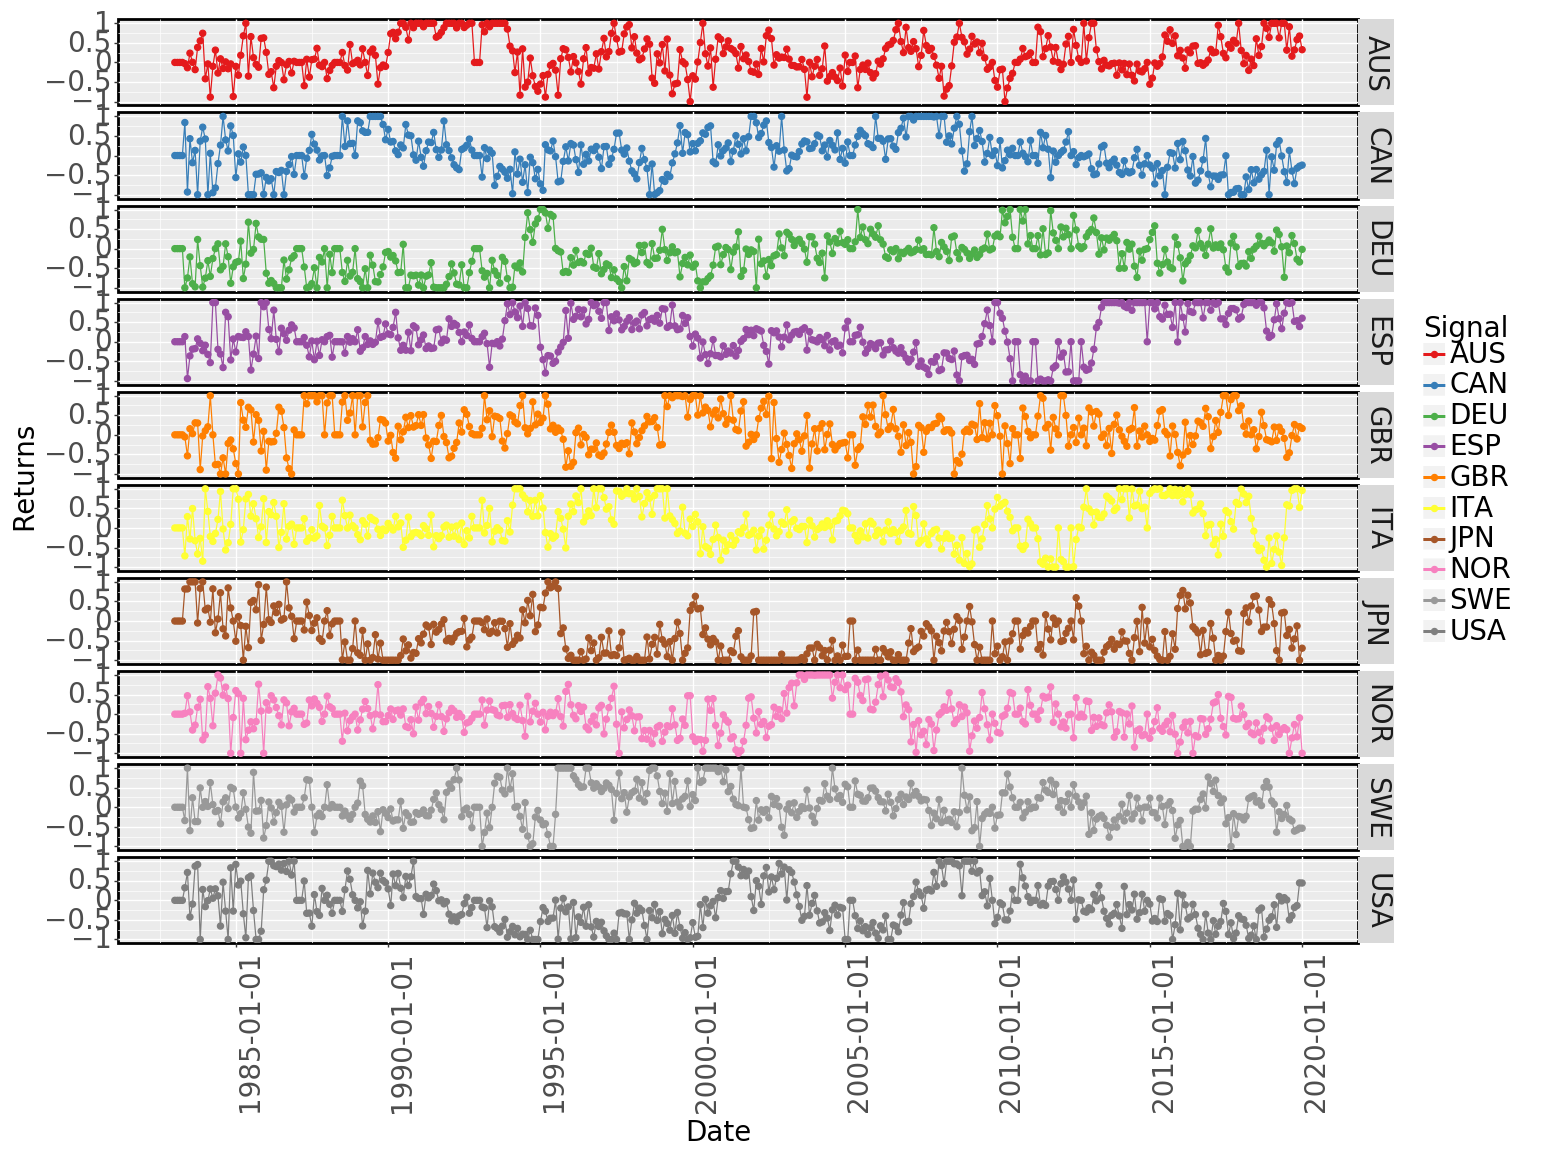

<ggplot: (8741467512426)>

In [7]:
foo = combo6_sig.copy()
foo['date'] = foo.index.to_timestamp()
foo = foo.melt(id_vars='date')

(
    ggplot(foo, aes(x='date', y='value', color='country')) +
        geom_line() +
        geom_point(size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        facet_grid('country~.') +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +

        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [159]:

def longize(sig, name):
    sig = sig.copy()
    sig = sig[['USA', 'JPN', 'GBR']]
    sig = sig.rolling(12, center=True).mean()
    sig = sig.loc['1985-01-01':'2019-01-01']
    sig['date'] = sig.index.to_timestamp()
    sig = sig.melt(id_vars='date')
    sig['name'] = name
    sig = sig.rename(columns={'variable': 'country'})
    sig['color'] = 'All' if name == 'Confidence' else sig['country']
    return sig

sigs = pd.concat([
    longize(combo1_sig, 'Combined'),
    #longize(inflation_sig, 'Inflation'),
    #longize(growth_sig, 'Growth'),
    longize(signalize(inflation_sig + growth_sig), 'Inf.+Growth'),
    #longize(growth_sig, 'Growth'),
    longize(momentum_sig, 'Momentum'),
    longize(bond_returns.pct_change(), 'Returns'),
#     longize(
#         pd.DataFrame.from_dict({'USA': combo6_sw, 'JPN': combo6_sw, 'GBR': combo6_sw, 'AUS': combo6_sw, 'DEU': combo6_sw, 'ITA': combo6_sw}, orient='columns'),
#         'Confidence'
#     )
])
sigs['name'] = pd.Categorical(sigs['name'], categories=['Returns', 'Combined', 'Momentum', 'Inf.+Growth'])

sigs

,date,country,value,name,color
0,1985-01-01,USA,0.013975,Combined,USA
1,1985-02-01,USA,0.120656,Combined,USA
2,1985-03-01,USA,0.060385,Combined,USA
3,1985-04-01,USA,0.000056,Combined,USA
4,1985-05-01,USA,0.000056,Combined,USA
...,...,...,...,...,...
1222,2018-09-01,GBR,0.004833,Returns,GBR
1223,2018-10-01,GBR,0.004444,Returns,GBR
1224,2018-11-01,GBR,0.004359,Returns,GBR
1225,2018-12-01,GBR,0.004821,Returns,GBR


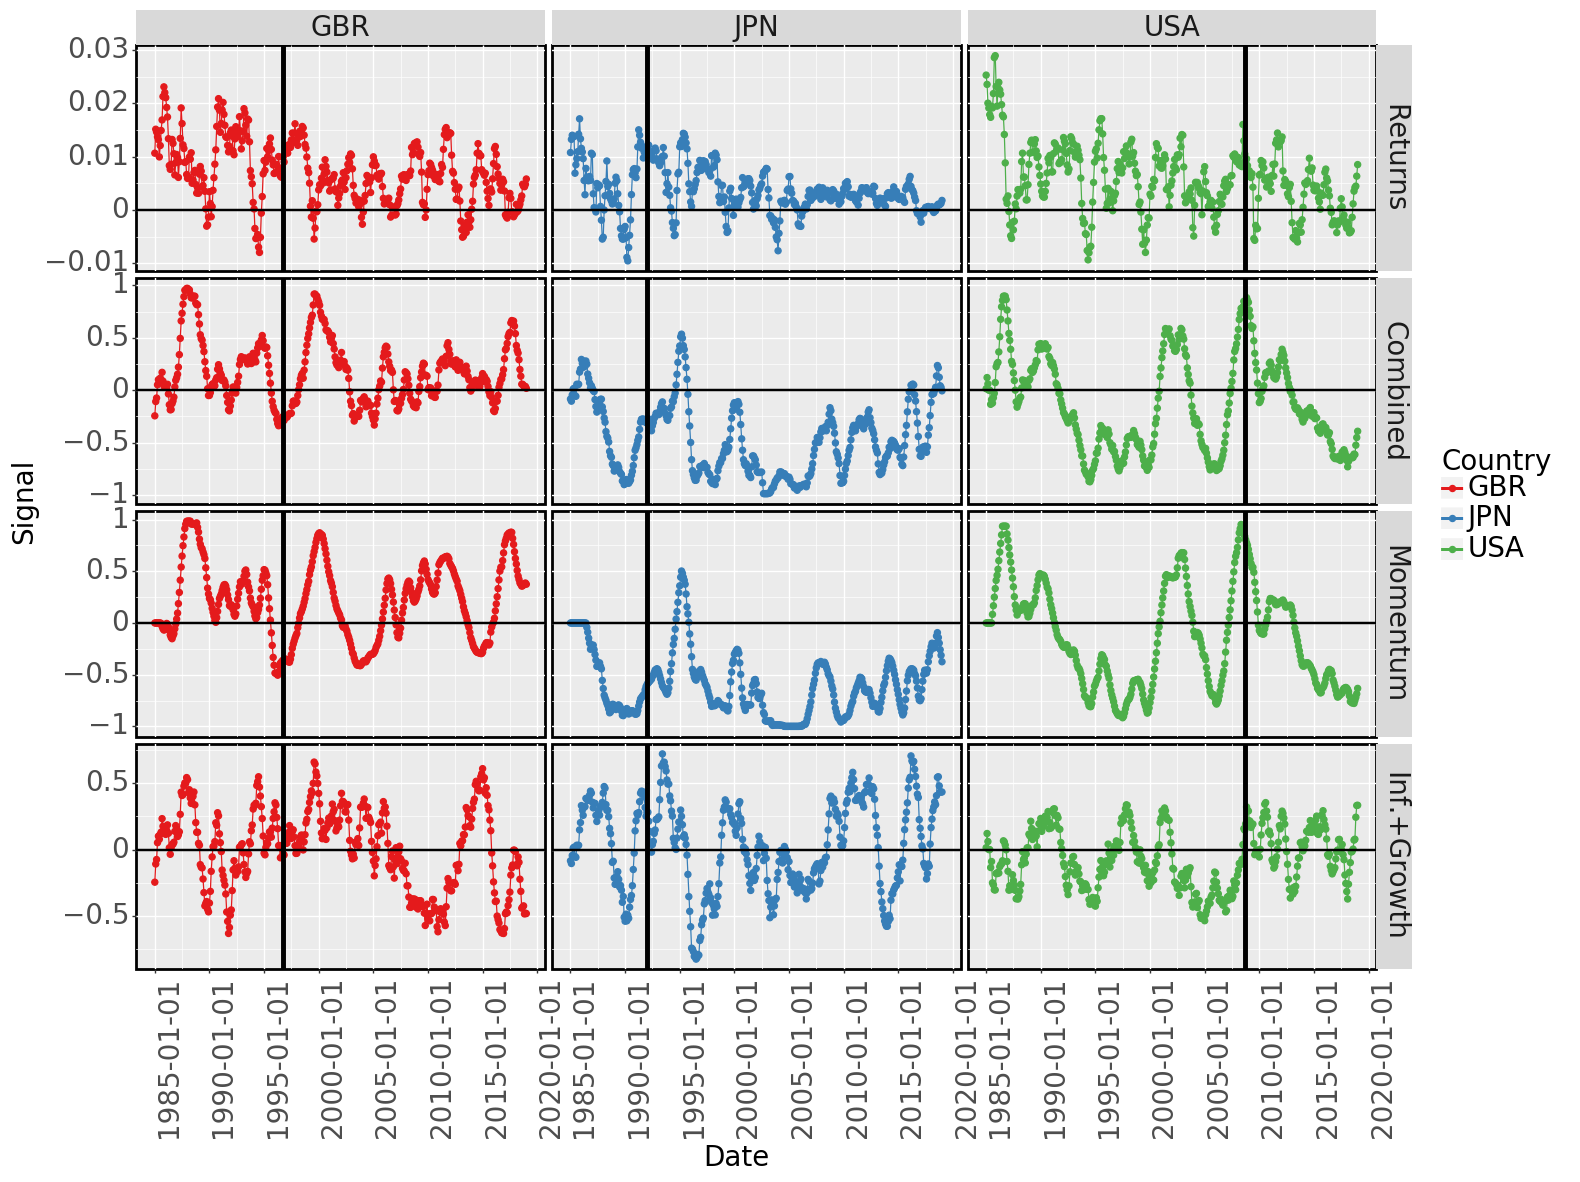

<ggplot: (8741421494718)>

In [167]:
foo = pd.DataFrame.from_dict({
    'date': ['1991-12-30', '1996-09-16', '2008-09-15'],
    'country': ['JPN', 'GBR', 'USA'],
    'color':['JPN', 'GBR', 'USA'],
}, orient='columns')

(
    ggplot(sigs, aes(x='date', y='value', color='color')) +
        geom_line() +
        geom_point(size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        facet_grid('name~country', scales='free_y') +
        ylab('Signal') +
        xlab('Date') +
        scale_x_date() +
#         geom_vline(xintercept='1991-12-30', color='blue', size=2) +
#         geom_vline(xintercept='1996-09-16', color='red', size=2) +
#         geom_vline(xintercept='2008-09-15', color='green', size=2) +
        geom_vline(foo, aes(xintercept='date'), size=2, color='black') +
        geom_hline(yintercept=0, color='black', size=1) +
        labs(color='Country') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [108]:
bond_returns.pct_change()

def longize(sig, name):
    sig = sig.copy()
    #sig = sig[['USA', 'JPN', 'GBR', 'AUS']]
    sig['date'] = sig.index.to_timestamp()
    sig = sig.melt(id_vars='date')
    sig = sig.set_index(['date', 'country'])
    sig = sig.rename(columns={'value': name})
    return sig


def ternary(x, thresh, as_nums=False):
    if x > thresh:
        return 1 if as_nums else 'Positive'
    if x > -thresh:
        return 0 if as_nums else 'Neutral'
    return -1 if as_nums else 'Negative'


signal_vs_return = pd.concat([
    longize(bond_returns.pct_change(), 'Actual Returns'),
    longize(combo1_sig, 'Signal'),
], axis=1)
signal_vs_return['country'] = signal_vs_return.index.to_series().map(lambda x: x[1])
signal_vs_return['signal_sign'] = signal_vs_return['Signal'].map(lambda x: ternary(x, 0.5))
signal_vs_return['ar_sign'] = signal_vs_return['Actual Returns'].map(lambda x: ternary(x - signal_vs_return['Actual Returns'].mean(), 0.01))

signal_vs_return

,,Actual Returns,Signal,country,signal_sign,ar_sign
date,country,,,,,
1983-01-01,JPN,NaN,1.000000,JPN,Positive,Negative
1983-02-01,JPN,NaN,-0.323016,JPN,Neutral,Negative
1983-03-01,JPN,NaN,-0.447092,JPN,Neutral,Negative
1983-04-01,JPN,NaN,1.000000,JPN,Positive,Negative
1983-05-01,JPN,NaN,0.818890,JPN,Positive,Negative
...,...,...,...,...,...,...
2019-09-01,SWE,-0.005962,-0.350222,SWE,Neutral,Negative
2019-10-01,SWE,-0.007135,-0.610742,SWE,Negative,Negative
2019-11-01,SWE,-0.015665,-0.580145,SWE,Negative,Negative


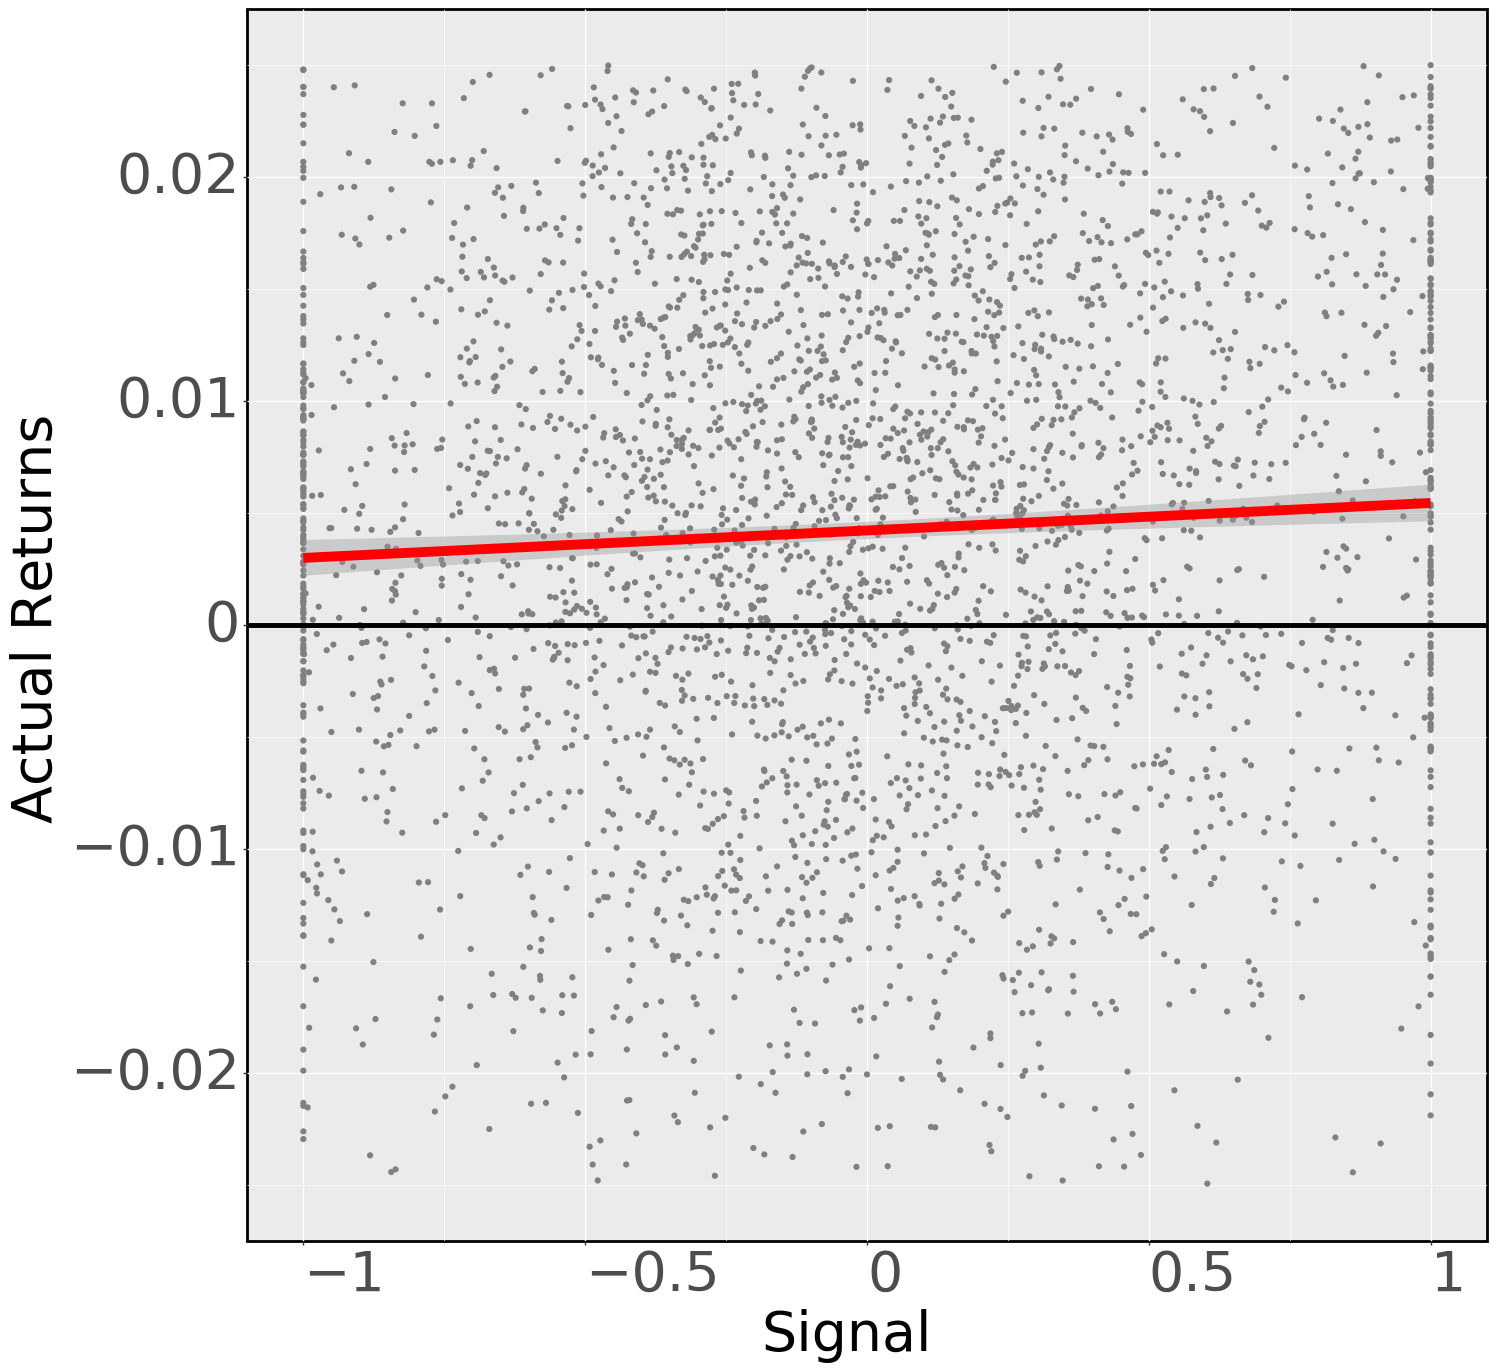

<ggplot: (8741466468486)>

In [145]:
Y = signal_vs_return['Actual Returns'].mean()
Y = 0
(
    ggplot(signal_vs_return, aes(x='Signal', y='Actual Returns')) +
        geom_point(color='grey') +
        geom_smooth(method='lm', color='red', size=4) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Actual Returns') +
        xlab('Signal') +
        ylim(-0.025, 0.025) +
        geom_hline(yintercept=Y, color='black', size=2) +
        theme(
            text=element_text(size=40),
            figure_size=(16, 16),
            legend_position='right',
            axis_text_x=element_text(size=40, angle=0, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [110]:
pd.crosstab(signal_vs_return['signal_sign'], signal_vs_return['ar_sign'])

ar_sign,Negative,Neutral,Positive
signal_sign,,,
Negative,237,415,152
Neutral,991,1221,617
Positive,227,354,236


In [116]:
bond_returns.pct_change()

def longize(sig, name):
    sig = sig.copy()
    #sig = sig[['USA', 'JPN', 'GBR', 'AUS']]
    sig['date'] = sig.index.to_timestamp()
    sig = sig.melt(id_vars='date')
    sig = sig.set_index(['date', 'country'])
    sig = sig.rename(columns={'value': name})
    return sig


def ternary(x, thresh, as_nums=False):
    if x > thresh:
        return 1 if as_nums else 'Positive'
    if x > -thresh:
        return 0 if as_nums else 'Neutral'
    return -1 if as_nums else 'Negative'


signal_vs_return = pd.concat([
    longize(bond_returns.pct_change(), 'Actual Returns'),
    longize(growth_sig, 'Signal'),
], axis=1)
signal_vs_return['country'] = signal_vs_return.index.to_series().map(lambda x: x[1])
signal_vs_return['signal_sign'] = signal_vs_return['Signal'].map(lambda x: ternary(x, 0.5))
signal_vs_return['ar_sign'] = signal_vs_return['Actual Returns'].map(lambda x: ternary(x - signal_vs_return['Actual Returns'].mean(), 0.01))

pd.crosstab(signal_vs_return['signal_sign'], signal_vs_return['ar_sign'])

ar_sign,Negative,Neutral,Positive
signal_sign,,,
Negative,279,373,142
Neutral,902,1294,661
Positive,274,323,202


In [128]:
bond_returns.pct_change()

def longize(sig, name):
    sig = sig.copy()
    #sig = sig[['USA', 'JPN', 'GBR', 'AUS']]
    sig['date'] = sig.index.to_timestamp()
    sig = sig.melt(id_vars='date')
    sig = sig.set_index(['date', 'country'])
    sig = sig.rename(columns={'value': name})
    return sig


def ternary(x, thresh, as_nums=False):
    if x > thresh:
        return 1 if as_nums else 'Positive'
    if x > -thresh:
        return 0 if as_nums else 'Neutral'
    return -1 if as_nums else 'Negative'


signal_vs_return = pd.concat([
    longize(bond_returns.pct_change(), 'Actual Returns'),
    longize(combo1_sig, 'Signal'),
], axis=1)
signal_vs_return['country'] = signal_vs_return.index.to_series().map(lambda x: x[1])
signal_vs_return['signal_sign'] = signal_vs_return['Signal'].map(lambda x: ternary(x, 0))
signal_vs_return['ar_sign'] = signal_vs_return['Actual Returns'].map(lambda x: ternary(x - signal_vs_return['Actual Returns'].mean(), 0.))

foo = pd.crosstab(signal_vs_return['signal_sign'], signal_vs_return['ar_sign'])
100 * (foo / foo.sum())


ar_sign,Negative,Positive
signal_sign,,
Negative,53.439803,48.705179
Positive,46.560197,51.294821


In [120]:
bond_returns.pct_change()

def longize(sig, name):
    sig = sig.copy()
    #sig = sig[['USA', 'JPN', 'GBR', 'AUS']]
    sig['date'] = sig.index.to_timestamp()
    sig = sig.melt(id_vars='date')
    sig = sig.set_index(['date', 'country'])
    sig = sig.rename(columns={'value': name})
    return sig


def ternary(x, thresh, as_nums=False):
    if x > thresh:
        return 1 if as_nums else 'Positive'
    if x > -thresh:
        return 0 if as_nums else 'Neutral'
    return -1 if as_nums else 'Negative'


signal_vs_return = pd.concat([
    longize(bond_returns.pct_change(), 'Actual Returns'),
    longize(inflation_sig, 'Signal'),
], axis=1)
signal_vs_return['country'] = signal_vs_return.index.to_series().map(lambda x: x[1])
signal_vs_return['signal_sign'] = signal_vs_return['Signal'].map(lambda x: ternary(x, 0.5))
signal_vs_return['ar_sign'] = signal_vs_return['Actual Returns'].map(lambda x: ternary(x - signal_vs_return['Actual Returns'].mean(), 0.01))

pd.crosstab(signal_vs_return['signal_sign'], signal_vs_return['ar_sign'])

ar_sign,Negative,Neutral,Positive
signal_sign,,,
Negative,248,366,203
Neutral,988,1242,622
Positive,219,382,180


In [146]:
pd.Series([-7.15,
12.7,
11.1,
18.5,
8.74,
17.4,
27.8,
22.5,
11.8,
27.9,
]).abs().mean()

16.559